In [7]:
!pip install -r ./requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 2.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 30.3 MB/s eta 0:00:0000:0100:01
  Using cached jmespath-1.0.1-py3-none-any.whl (20 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 2.9 MB/s eta 0:00:00


In [8]:
import numpy as np
import os, random, pathlib, warnings, itertools, math
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
from PIL import Image 
from PIL import ImageEnhance
from shutil import rmtree

import boto3
import botocore
from botocore import UNSIGNED
from botocore.client import Config

from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3,preprocess_input
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dense, Dropout

In [ ]:
K.clear_session()


In [ ]:
local_dest_dir = os.path.join(os.getcwd(),"TrainingData/")


rmtree(local_dest_dir)
os.makedirs(local_dest_dir)

import urllib3
urllib3.disable_warnings()

# Fetch all env variable these values will be fetched from Data Connection setup 

access_key = os.getenv("AWS_ACCESS_KEY_ID")
secret = os.getenv("AWS_SECRET_ACCESS_KEY")
s3endpoint = os.getenv("AWS_S3_ENDPOINT")
bucket_name = os.getenv("AWS_S3_BUCKET")


'''
 Download all files from local MinIO server to Directory TrainingData
'''

s3 = boto3.resource('s3',aws_access_key_id=access_key,aws_secret_access_key=secret,config=boto3.session.Config(signature_version='s3v4'),
    verify=False,endpoint_url=s3endpoint)
s3_client = s3.meta.client

bucket = s3.Bucket(bucket_name)

objects = bucket.objects.filter(Prefix="/")
for obj in objects:
    path, filename = os.path.split(obj.key)
    if len(path) != 0 and not os.path.exists(os.path.join(local_dest_dir, path)):
       os.makedirs(os.path.join(local_dest_dir, path))
    if not obj.key.endswith("/"):
        download_to = local_dest_dir + path + '/' + filename if path else filename
        s3_client.download_file(bucket_name,obj.key,download_to)
        
print ("Download Completed")

In [12]:
dataset='./TrainingData'

train_folder = os.path.join(dataset,"train")
test_folder = os.path.join(dataset,"validation")
validation_folder = os.path.join(dataset,"test")

In [ ]:
IMAGE_SIZE = [224, 224]

inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in inception.layers:
    layer.trainable = False

x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

prediction = Dense(15, activation='softmax')(x)

model = Model(inputs=inception.input, outputs=prediction)

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

model.summary();

train_datagen = image.ImageDataGenerator(rescale = 1./255,
                                         shear_range = 0.2,
                                         zoom_range = 0.2,
                                         horizontal_flip = True)

test_datagen = image.ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(
    train_folder,
    target_size = (224, 224),
    batch_size = 64,
    class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(
    test_folder, 
    target_size = (224, 224),
    batch_size = 64, 
    class_mode = 'categorical')

class_map = training_set.class_indices
print(class_map)

In [ ]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

model.save('model_inceptionV3_epoch5.h5')

In [9]:
K.clear_session()
path_to_model='./model_inceptionV3_epoch5.h5'
print("Loading the model..")
model = load_model(path_to_model)
print("Done!")

Loading the model..
Done!


In [23]:
category={
    0: 'Bean', 1: 'Bitter Gourd', 2: 'Bottle Gourd', 3 : 'Brinjal', 4: "Broccoli", 5: 'Cabbage', 6: 'Capsicum', 7: 'Carrot', 8: 'Cauliflower',
    9: 'Cucumber', 10: 'Papaya', 11: 'Potato', 12: 'Pumpkin', 13 : "Radish", 14: "Tomato"
}

def predict_image(filename,model):
    img_ = image.load_img(filename, target_size=(224, 224))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0) 
    img_processed /= 255.   
    
    prediction = model.predict(img_processed)
    index = np.argmax(prediction)
    
    plt.title("Prediction - {}".format(category[index]))
    plt.imshow(img_array)

1/1 [==============================] - 0s 69ms/step


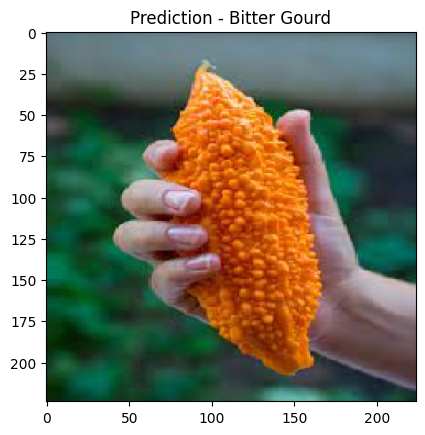

In [30]:
dataset='./Vegetable Images'

train_folder = os.path.join(dataset,"train")
test_folder = os.path.join(dataset,"validation")
validation_folder = os.path.join(dataset,"test")

#predict_image(os.path.join(validation_folder,'Cauliflower/1064.jpg'),model)
#predict_image(os.path.join(validation_folder,'Bitter_Gourd/1202.jpg'),model)

#predict_image(os.path.join(validation_folder,'Papaya/1266.jpg'),model)
predict_image("/Users/arunhariharan/Downloads/VegetableTest/bittergourdtest2.jpeg",model)